In [ ]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Hugo's Portfolio/Introducing NBEATSx to Realized Volatility Forecasting (Research)/Main/Robust Tests/European Stock/STOXX50E Realized Volatility (NBEATSx).xlsx",index_col='Date',parse_dates=True)


In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7)]
validation_length=int(len(df['y'])*0.7)-int(len(df['y'])*0.6)

In [ ]:
n_inputs = [12,21,63,84,126,189,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs = [100,150,200]
learning_rate=[0.05,0.005,0.0005,0.0001]
num_lr_decays=[10,5,3,5]
dropouts=[0,0.2,0.4]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[80, 90]),DistributionLoss(distribution='StudentT', level=[80, 90])]
RMSE = []
Accuracy = []

# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 77011559


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 109207085


Epoch: 200 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 2.8045518747391305 | Accuracy: -57766.454535723155


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 69728687


Epoch: 100 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0018523498181884713 | Accuracy: 65.50018495304737


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 78887481


Epoch: 150 | Inputs: 12 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.002032087922752571 | Accuracy: 60.71337887667381


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62359585


Epoch: 100 | Inputs: 12 | MLP units: [[100, 100], [100, 100]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0019337337608465197 | Accuracy: 62.45610759798124


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 189 | MLP units: [[712, 712], [712, 712]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0018300703170892718 | Accuracy: 65.4390611667476


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 68917032


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 2742465


Epoch: 200 | Inputs: 12 | MLP units: [[250, 250], [250, 250]] | Loss: MQLoss() | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.001755759728655604 | Accuracy: 67.670797555548


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 73979411


Epoch: 100 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.0019120825062405656 | Accuracy: 62.76113731231081


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 31741743


Epoch: 150 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 0.0018148402562810182 | Accuracy: 65.40685799945926


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 74872895


Epoch: 150 | Inputs: 12 | MLP units: [[250, 250], [250, 250]] | Loss: MAE() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 0.0026509113365646136 | Accuracy: 48.77837582984004


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 200 | Inputs: 12 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0019265664521639551 | Accuracy: 63.91485722619058


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 119836822


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 58171488


Epoch: 200 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.005
RMSE: 0.0018753254879453334 | Accuracy: 67.35936715000851


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 117112257


Epoch: 150 | Inputs: 84 | MLP units: [[100, 100], [100, 100]] | Loss: MAE() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 0.006173301726927561 | Accuracy: -18.545782538245305


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 47660990


Epoch: 100 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0018028731599706903 | Accuracy: 65.83881467742853


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 14367509


Epoch: 100 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: DistributionLoss() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.005
RMSE: 0.0019378871102487363 | Accuracy: 62.19353925876763


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 200 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0018150791607357334 | Accuracy: 65.27853420907732


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 84048432


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 89347978


Epoch: 150 | Inputs: 12 | MLP units: [[250, 250], [250, 250]] | Loss: MAE() | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 0.004552164724790916 | Accuracy: 14.019392894897054


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 49891302


Epoch: 200 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: MQLoss() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.0019527260649226648 | Accuracy: 64.09929034282523


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 114427568


Epoch: 100 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0019869575625785403 | Accuracy: 60.8406651432599


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 40349855


Epoch: 150 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.05
RMSE: 1.7656757886363337 | Accuracy: -33164.7796851462


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 150 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.05
RMSE: 0.02389988915103884 | Accuracy: -369.10838831980124


Epoch: 200 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.005
RMSE: 0.0018753254879453334 | Accuracy: 67.35936715000851

# H=1 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [ ]:
model = NBEATSx(h=1, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.005,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 63174358


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
Accuracy

[63.49007791190084,
 64.92778741447525,
 62.32267706515409,
 61.3463346391591,
 64.41572465613703,
 62.69019265827755,
 63.51066790724966,
 63.875127674082755,
 63.35946782205987,
 63.70715827846697,
 63.91985496055159,
 61.87734020119662,
 64.10617713907027,
 63.333801314244944,
 62.66953506649144]

In [ ]:
RMSE

[0.0029378065507759247,
 0.002960177248530113,
 0.0029219625840737275,
 0.0029717438779431346,
 0.002947927962346512,
 0.0029378963672880153,
 0.0028744412074840943,
 0.0029450667284909014,
 0.0028870212654463234,
 0.002963734019075323,
 0.002968022240645614,
 0.0029507995201275756,
 0.0029122562690090466,
 0.002969937207877492,
 0.0029835555284736426]

In [ ]:
Quasilikelihood

[0.093443904663299,
 0.09541003271335581,
 0.09793092034465714,
 0.09133099580163127,
 0.09493542884998314,
 0.09642367431903859,
 0.09069446839740966,
 0.09682548218535669,
 0.09130174800735803,
 0.09229557745464838,
 0.09775700459808123,
 0.09273420512671511,
 0.090999407348028,
 0.09852446117994354,
 0.09294203985551178]

Text(0, 0.5, 'STOXX50E Realized Volatility')

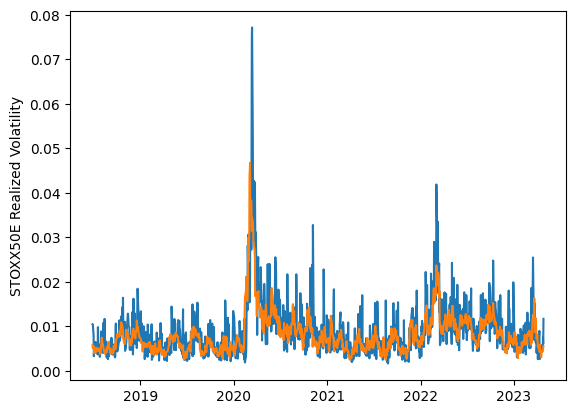

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("STOXX50E Realized Volatility")

# H=3 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [ ]:
test_length%3

1

In [ ]:
model = NBEATSx(h=3, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.005,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=9,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-1,step_size=3)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 41979435


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.002793685066763187,
 0.00280841150938058,
 0.0028579024752462124,
 0.0028812206096909578,
 0.0028124990861344555,
 0.002814897799797569,
 0.0028253245203995947,
 0.002845992697081279,
 0.00281841355173185,
 0.0028093920345240663,
 0.0028057215046618325,
 0.002828489518292763,
 0.0028271913396979505,
 0.00282282517376603,
 0.002844126031512619]

In [ ]:
Accuracy


[64.95428304063427,
 65.69260188101008,
 62.63226545597779,
 63.82400100393695,
 66.26764671659072,
 65.72559467436503,
 64.77464526507539,
 63.99562376079074,
 65.44013919314212,
 65.81229035852074,
 64.88687805401321,
 65.46992271278202,
 65.45261491370162,
 65.17533104301836,
 65.50436004048595]

In [ ]:
Quasilikelihood

[0.0877554780129318,
 0.09071911983854894,
 0.08504687776387762,
 0.0950280763610779,
 0.09039737474696422,
 0.09093164496420961,
 0.08858531945272237,
 0.08779577086411296,
 0.09064958415512771,
 0.09392148675745463,
 0.08551403729975723,
 0.09073129965777413,
 0.09151403812412837,
 0.08984122978585776,
 0.09138067764697512]

Text(0, 0.5, 'STOXX50E Realized Volatility')

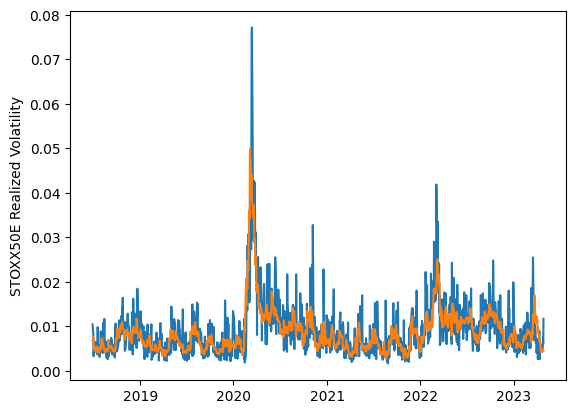

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("STOXX50E Realized Volatility")

# H=5 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=5, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.005,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=5)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 79544768


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.002823474773952437,
 0.0028031964160714026,
 0.0028212703548233602,
 0.0028216144168943637,
 0.0027741770488795333,
 0.002784654417011241,
 0.002821847026849186,
 0.0027777094812908953,
 0.0027827309803872013,
 0.0028149008382573042,
 0.0028229637325295136,
 0.002831567791406128,
 0.002824979811545506,
 0.00276229780234182,
 0.0028070971888615377]

In [ ]:
Accuracy

[65.56533012620646,
 66.39506081234626,
 64.92562112210103,
 65.23679353219947,
 66.52215126523298,
 66.6341600926717,
 65.33854228889216,
 66.4074983058348,
 65.74146632259648,
 65.39680618308662,
 65.86215134997852,
 64.9001722854773,
 63.953934702123874,
 66.01499346840187,
 65.58449271228308]

In [ ]:
Quasilikelihood

[0.08794284213036117,
 0.08550452187042835,
 0.08627073480973789,
 0.08691277798463602,
 0.08632528173192623,
 0.08841737611740115,
 0.08749828217517429,
 0.0858748377578012,
 0.08371824932977201,
 0.08772795002416994,
 0.08988732499415181,
 0.08620550331894451,
 0.08327258382749718,
 0.08426665620274644,
 0.08743790623954201]

Text(0, 0.5, 'STOXX50E Realized Volatility')

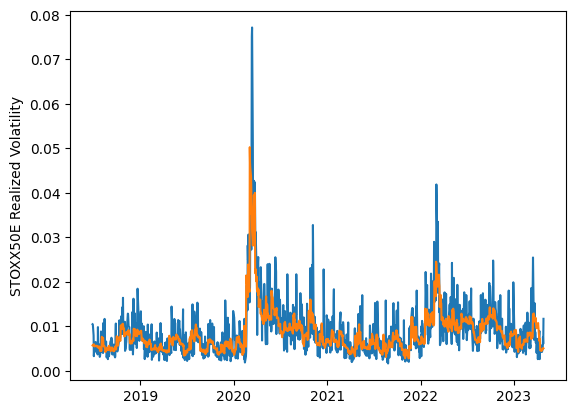

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("STOXX50E Realized Volatility")

# H=10 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=10, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.005,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=10)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 56270480


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.0029378193409202746,
 0.002936434142910624,
 0.0029365104890654125,
 0.0029356903452167162,
 0.0028965233666421184,
 0.0029426080367039257,
 0.0029058569376617873,
 0.0029056449008109894,
 0.0029444634596418502,
 0.002937342347672745,
 0.002911663988024112,
 0.0029367624451711225,
 0.002921106952209387,
 0.0029242480754779216,
 0.002955211388041764]

In [ ]:
Accuracy

[64.13884374100626,
 65.03853430456554,
 63.79397321834003,
 64.21721233252569,
 66.54111614435085,
 64.64066646602019,
 65.30385425169175,
 65.51159736264339,
 63.95119111803329,
 64.40626258813545,
 64.7176068569321,
 63.33332017752422,
 64.25776315312793,
 65.03428602347805,
 63.488661946313776]

In [ ]:
Quasilikelihood

[0.09097065190406446,
 0.09425202972906126,
 0.08896470804158613,
 0.09127879366975818,
 0.0948253122200872,
 0.092784062351157,
 0.09056721949661513,
 0.09362261922583526,
 0.08927276933491435,
 0.09101316787510476,
 0.08969794041102765,
 0.0867630551795292,
 0.08900856496451028,
 0.09232863167224116,
 0.08969924186298635]

Text(0, 0.5, 'STOXX50E Realized Volatility')

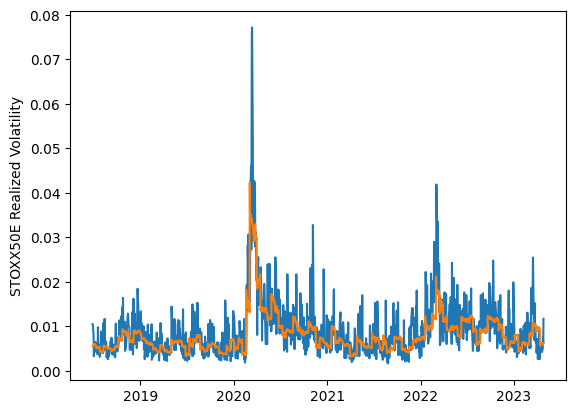

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("STOXX50E Realized Volatility")

# H=22 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=22, input_size=12,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.005,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=200,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=22,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=22)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 42201375


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.00349103718033974,
 0.0034252001514015877,
 0.003474435516892394,
 0.00341656256407698,
 0.003451077820947816,
 0.003453405447430025,
 0.0034452168294431917,
 0.0034796506659003773,
 0.003468759573461758,
 0.0033705596943202215,
 0.0034314701806808035,
 0.00344745302719198,
 0.0034758021437984988,
 0.0034245530383338178,
 0.0035026118364603538]

In [ ]:
Accuracy

[55.69430668640323,
 58.29154138665966,
 56.645875083838646,
 58.00984978031227,
 57.548641531050805,
 56.42251376480871,
 57.01479530602549,
 56.57743742264139,
 56.14472039879883,
 59.03726969811047,
 56.75240561612143,
 57.79122110482391,
 55.70636481707689,
 56.6718312305851,
 55.66917022655738]

In [ ]:
Quasilikelihood

[0.12404308109921514,
 0.13050037860871982,
 0.13076246302338956,
 0.13268074340401279,
 0.12976823733548173,
 0.12917638885885246,
 0.12870040930372065,
 0.12985429320392924,
 0.12791497315237602,
 0.131844473095895,
 0.12579017707823265,
 0.1342167109208228,
 0.12699203634312642,
 0.1251116815445679,
 0.13831077822281224]

Text(0, 0.5, 'STOXX50E Realized Volatility')

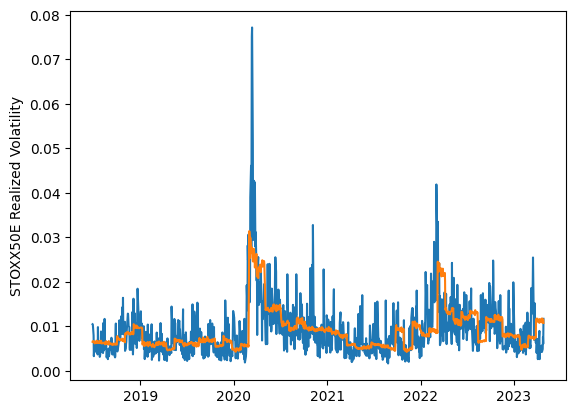

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("STOXX50E Realized Volatility")